In [1]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc
import random, re, math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.losses import Loss
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from kaggle_datasets import KaggleDatasets

import cv2

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [256, 256]
EPOCHS = 7
BATCH_SIZE = max(32 * strategy.num_replicas_in_sync, 64)

TF_RECORDS_FILES = KaggleDatasets().get_gcs_path('512x512-melanoma-tfrecords-70k-images')
# TF_RECORDS_FILES = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(256,256))
# TF_RECORDS_FILES = "../input/siim-isic-melanoma-classification"
TRAIN_CSV = "../input/siim-isic-melanoma-classification/train.csv"
TEST_CSV = "../input/siim-isic-melanoma-classification/test.csv"
SUBMISSION_CSV = "submission.csv"

# Learning rate Scheduler

Learning rate schedule: 5e-06 to 0.0004 to 8.11e-06


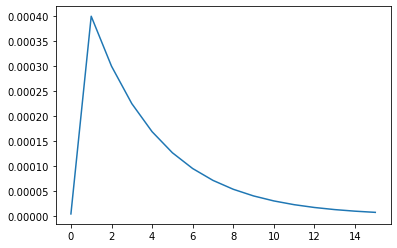

In [5]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.000005
LR_MAX = 0.0004
LR_MIN = 0.000001
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(16)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Data Augmentation

In [6]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 180. * tf.random.normal([1],dtype='float32')
    shr = 2. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')*0.12
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')*0.12
    h_shift = 8. * tf.random.normal([1],dtype='float32') 
    w_shift = 8. * tf.random.normal([1],dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
    im = tf.reshape(d,[DIM,DIM,3])
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_flip_up_down(im)
    im = tf.image.random_brightness(im, 0.2)
    im = tf.image.random_contrast(im, 0.9, 1.1)
    im = tf.image.random_hue(im, 0.05)
    return im

def transform_batch(images, feats, labels):
    ret = tf.map_fn(transform, images)
    return ret, feats, labels


# Data Loading

In [7]:
train_feature_description = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
#     'sex': tf.io.FixedLenFeature([], tf.int64),
    'age_approx': tf.io.FixedLenFeature([], tf.int64),
    'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    "target": tf.io.FixedLenFeature([], tf.int64)
}

test_feature_description = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
#     'sex': tf.io.FixedLenFeature([], tf.int64),
    'age_approx': tf.io.FixedLenFeature([], tf.int64),
    'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
}


def parse_example(W_LABEL):
    def function(ex):
        if W_LABEL:
            feature_description = train_feature_description
        else:
            feature_description = test_feature_description
        return tf.io.parse_single_example(ex, feature_description)
    return function

def decode_image(W_LABEL, IMAGE_SIZE):
    def function(ex):
        image = ex['image']
        age = (ex['age_approx']-51)/(20)
#         source = tf.cast(tf.one_hot(ex['source'], 3), tf.float32)
        ana = tf.cast(tf.one_hot(ex['anatom_site_general_challenge'], 7), tf.float32)
        feats = tf.concat([ana, tf.cast(tf.expand_dims(age, 0), tf.float32)], 0)
        if W_LABEL:
            label = ex['target']
            feature_description = train_feature_description
        else:
            feature_description = test_feature_description
            image_name = ex['image_name']
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
        image = tf.image.resize(image, IMAGE_SIZE)
        image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
        ex['image'] = image
        if W_LABEL:
            return image, feats, label
        return image, feats, image_name
    return function

def increase_pos(images, feats, labels):
    LEN = tf.size(labels)
    pos = tf.squeeze(tf.where(tf.equal(labels, 1)), -1)
    neg = tf.squeeze(tf.where(tf.equal(labels, 0)), -1)
    if tf.size(pos) == 0:
        return images, labels
    if tf.size(neg) == 0:
        return images, labels
    neg = tf.tile(neg, [1+int(((LEN)//(2*tf.shape(neg)[0])))], name='neg_tile')
    neg = neg[0:LEN//2]
    pos = tf.tile(pos, multiples=[1 + (LEN)//(2*tf.size(pos))], name='pos_tile')
    pos = pos[0:LEN//2]
    indices = tf.concat([pos, neg], 0)
    indices = tf.random.shuffle(indices)
    imgs = tf.gather(images, indices)
    lbls = tf.gather(labels, indices)
    fts = tf.gather(feats, indices)
    return imgs, fts, lbls

def input_to_dict(images, feats, labels):
    
    return {'in_img': images, 'in_feats': feats}, labels


class DataLoader:

    def __init__(self, IMAGE_SIZE, BATCH_SIZE, TFR_FILES, CSV_FILE,
                CACHE=True, W_LABELS=False, SPLIT=1.0, FROM_END=False, VAL=False):

        self.IMAGE_SIZE = IMAGE_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.TFR_FILES = TFR_FILES
        self.CSV_FILE = CSV_FILE
        self.CACHE = CACHE
        self.W_LABELS = W_LABELS
        self.SPLIT = SPLIT
        self.FROM_END = FROM_END
        self.VAL = VAL
        

        self.load_csv()
        self.create_ds()

    def load_csv(self):
        pass
#         self.csv_df = pd.read_csv(self.CSV_FILE)
#         self.csv_size = self.csv_df.size
#         self.datasize = self.csv_size
    
    def create_ds(self):
        ignore_order = tf.data.Options()
        if self.W_LABELS:
            ignore_order.experimental_deterministic = False
        
        self.dataset = tf.data.TFRecordDataset(self.TFR_FILES, num_parallel_reads = AUTO)
        if self.CACHE:
#             self.dataset = self.dataset.cache()
            self.dataset = self.dataset.with_options(ignore_order)
        self.dataset = self.dataset.map(parse_example(self.W_LABELS), num_parallel_calls=AUTO)
        
        self.dataset = self.dataset.map(decode_image(self.W_LABELS, self.IMAGE_SIZE), num_parallel_calls=AUTO)
        if self.W_LABELS:
            self.dataset = self.dataset.repeat()
#             self.dataset = self.dataset.batch(2048)
#             self.dataset = self.dataset.map(increase_pos, num_parallel_calls=AUTO)
#             self.dataset = self.dataset.unbatch()
            self.dataset = self.dataset.shuffle(1024)
        self.dataset = self.dataset.batch(self.BATCH_SIZE, self.W_LABELS)
        if self.W_LABELS and (not self.VAL):
            self.dataset = self.dataset.map(transform_batch, num_parallel_calls=AUTO)
#         self.dataset = self.dataset.map(merge_feat, num_parallel_calls=AUTO)
        self.dataset = self.dataset.map(input_to_dict, num_parallel_calls=AUTO)
        self.dataset = self.dataset.prefetch(AUTO)
        
    def get_dataset(self):
        return self.dataset
    
    def get_iterations(self):
        return self.datasize // self.BATCH_SIZE
        
class TrainDataLoader(DataLoader):
    """
    Also used for validation (by setting VAL=True)
    """
    def __init__(self, IMAGE_SIZE, BATCH_SIZE, VAL=False, CACHE=True, TFR_FILES=None):
        if TFR_FILES is None:
            TFR_FILES = tf.io.gfile.glob(TF_RECORDS_FILES + '/train*.tfrec')
            if VAL:
                TFR_FILES = TFR_FILES[-5:]
            else:
                TFR_FILES = TFR_FILES[0:-5]
        super(TrainDataLoader, self).__init__( IMAGE_SIZE, BATCH_SIZE, TFR_FILES, CSV_FILE=TRAIN_CSV,
                CACHE=CACHE, W_LABELS=True, VAL= VAL)

class TestDataLoader(DataLoader):
    def __init__(self, IMAGE_SIZE, BATCH_SIZE):
        TFR_FILES = tf.io.gfile.glob(TF_RECORDS_FILES + '/test*.tfrec')
        super(TestDataLoader, self).__init__(IMAGE_SIZE, BATCH_SIZE, TFR_FILES, CSV_FILE=TEST_CSV,
                CACHE=False, W_LABELS=False, SPLIT=1.0, FROM_END=False)

# Examples from Data (after Augementation)

In [8]:
train_dataset = TrainDataLoader(IMAGE_SIZE, BATCH_SIZE, False, True)
val_dataset = TrainDataLoader(IMAGE_SIZE, BATCH_SIZE, True, True)

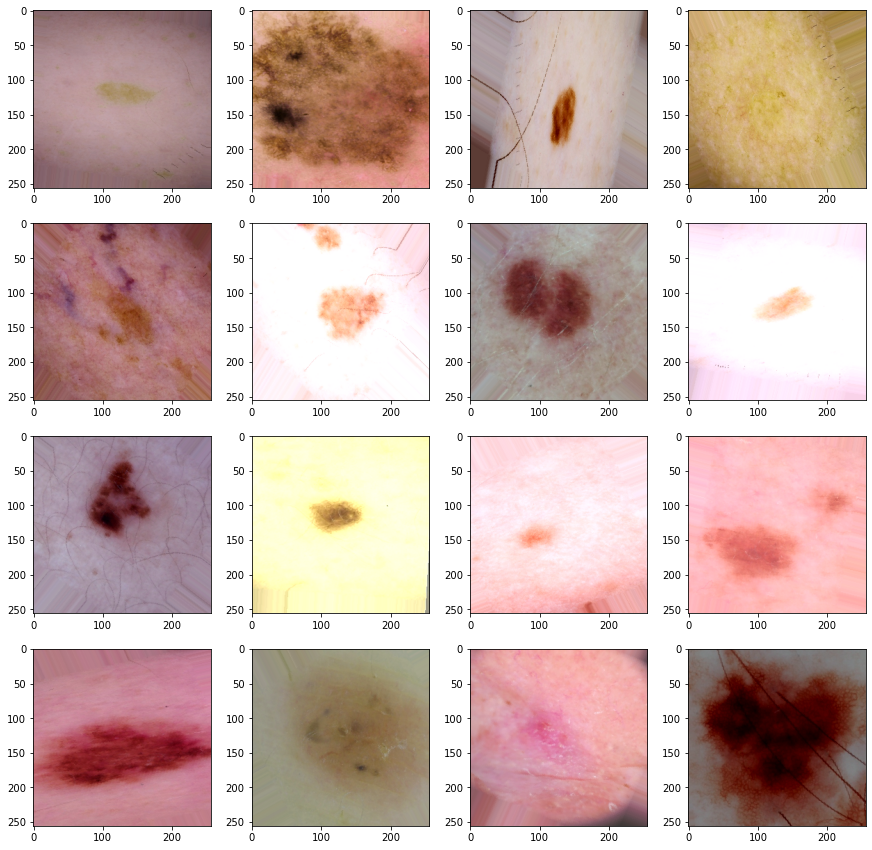

In [9]:
for im, l in train_dataset.get_dataset().take(1):
    plt.figure(figsize=(15,int(15*4/4)))
    for i, m in enumerate(im['in_img'][0:16]):
        plt.subplot(4, 4, 1 + i)
        plt.imshow(m)

# Training

In [10]:
def loss_function(y_true, y_pred):
    return tf.math.reduce_mean(-(y_true*tf.math.log(y_pred)*0.99 + (1-y_true)*tf.math.log(1-y_pred)*0.01))

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [11]:
pres = [
        efn.EfficientNetB5,
        efn.EfficientNetB6,
        efn.EfficientNetB3,
        efn.EfficientNetB4,
        efn.EfficientNetB4,
        efn.EfficientNetB4
]
dropouts = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
models = []
hists = []
TFR_FILES = np.asarray(tf.io.gfile.glob(TF_RECORDS_FILES + '/train*.tfrec'))
kf = KFold(n_splits=6)
i = 0
for train, val in kf.split(TFR_FILES):
    print(pres[i], dropouts[i])
    train = TFR_FILES[train]
    val = TFR_FILES[val]
    train_dataset = TrainDataLoader(IMAGE_SIZE, BATCH_SIZE, False, True, train)
    val_dataset = TrainDataLoader(IMAGE_SIZE, BATCH_SIZE, True, True, val)
    with strategy.scope():
        pre = pres[i](weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
        pre.trainable=True
        model = tf.keras.Sequential([
            pre,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(dropouts[i]),
            tf.keras.layers.Dense(32, 'relu')
        ])
        in_img = tf.keras.layers.Input((*IMAGE_SIZE, 3), name='in_img')
        in_feats = tf.keras.layers.Input((8), name='in_feats')
        y_img = model(in_img)
        y_feats = tf.keras.layers.Dense(32, 'relu')(in_feats)
        y = tf.keras.layers.Concatenate(axis=1)([y_img, y_feats])
        y = tf.keras.layers.Dropout(dropouts[i]/2)(y)
        y = tf.keras.layers.Dense(1)(y)
        y = tf.keras.layers.Activation('sigmoid')(y)
        model = Model(inputs=[in_img, in_feats], outputs=y)
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
        model.compile('adam', loss=loss, metrics=[ 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
            get_f1, 'AUC'
        ])
    hist = model.fit(train_dataset.get_dataset(), 
           steps_per_epoch=202,#train_dataset.get_iterations(), 
           epochs=EPOCHS,
          callbacks = [lr_callback],
          validation_data=val_dataset.get_dataset(),
          validation_steps=34,
            verbose=0)
    print('train_auc', hist.history['accuracy'])
    print('val_auc', hist.history['val_accuracy'])
    print('train_acc', hist.history['auc'])
    print('val_acc', hist.history['val_auc'])
    models.append(model)
    hists.append(hist)
    i += 1
    if i == 5: 
        """
        using just 5 models because RAM gets full while running randForest with 6 models
        better solution suggestion would be really appreciated
        """
        break

<function EfficientNetB5 at 0x7f1c4e55b5f0> 0.0
115515392/115515256 [==============================] - 2s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00030025.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002254375.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000169328125.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00012724609375.

Epoch 00007: LearningRateScheduler reducing learning rate to 9.56845703125e-05.
train_auc [0.7232363820075989, 0.9208500981330872, 0.932375431060791, 0.939143717288971, 0.9432626962661743, 0.9474009871482849, 0.950417697429657]
val_auc [0.8288143277168274, 0.9354320168495178, 0.9348575472831726, 0.9435891509056091, 0.943474292755127, 0.9461167454719543, 0.9505974054336548]
train_acc [0.6470176577568054, 0.869100034236908, 0.916113317

In [12]:
aucs, models = zip(*sorted(zip([hist.history['val_auc'][-1] for hist in hists], models)))
models = list(models)
aucs = list(aucs)
# models = models[2:]

print(aucs)

[0.9472655057907104, 0.9519633054733276, 0.953703761100769, 0.9542904496192932, 0.9552451372146606]


# Random Forest model parameter tuning

In [13]:
with strategy.scope():
    in_img = tf.keras.layers.Input((*IMAGE_SIZE, 3), name='in_img')
    in_feats = tf.keras.layers.Input((8), name='in_feats')
    preds = []
    for model in models:
        model.trainable = False
        temp_mod = Model(model.input, model.layers[-2].output)
        preds.append(temp_mod({'in_img': in_img, 'in_feats': in_feats}))
    y = tf.keras.layers.Concatenate(axis=1)(preds)
    y = tf.keras.layers.Dense(1, 'sigmoid')(y)
    forest = Model([in_img, in_feats], y)
    
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
    forest.compile('adam', loss=loss, metrics=[ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
        get_f1, 'AUC'
    ])
train_dataset = TrainDataLoader(IMAGE_SIZE, BATCH_SIZE//len(models), False, True, TFR_FILES) # with augmentation
forest.fit(train_dataset.get_dataset(), 
           steps_per_epoch=236*len(models),#train_dataset.get_iterations(), 
           epochs=5,
          callbacks = [lr_callback]
         )


Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/5
1180/1180 [==============================] - 279s 237ms/step - loss: 0.4656 - get_f1: 0.1980 - precision: 0.2581 - accuracy: 0.8174 - auc: 0.7323 - recall: 0.5435 - lr: 5.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 2/5
1180/1180 [==============================] - 278s 235ms/step - loss: 0.2108 - get_f1: 0.2470 - precision: 0.6431 - accuracy: 0.9320 - auc: 0.9013 - recall: 0.5584 - lr: 4.0000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00030025.
Epoch 3/5
1180/1180 [==============================] - 281s 238ms/step - loss: 0.1596 - get_f1: 0.2588 - precision: 0.8129 - accuracy: 0.9489 - auc: 0.9474 - recall: 0.5688 - lr: 3.0025e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002254375.
Epoch 4/5
1180/1180 [==============================] - 277s 234ms/step - loss: 0.1530 - get_f1: 0.2627 - precision: 0.8306 - accuracy: 0.9514

# Prediction

In [14]:
def pred_to_label(pred, hthresh=0.766, lthresh=0.233):
    if pred < lthresh:
        return 0.0
    elif pred > hthresh:
        return 1.0
    else:
        return pred

test_dataset = TestDataLoader(IMAGE_SIZE, BATCH_SIZE)
row_list = []
row_list_threshed = []

for batch in test_dataset.get_dataset():
    res = forest.predict_on_batch(batch[0])
#     for model in models:
#         if res is None:
#             res = model.predict_on_batch(batch[0])
#         else:
#             res += model.predict_on_batch(batch[0])
    preds = [[img_name.decode("utf-8"), pred[0]] for img_name, pred in zip(batch[1].numpy(), res)]
    row_list = row_list + preds

    preds_threshed = [[img_name.decode("utf-8"), pred_to_label(pred[0])] for img_name, pred in zip(batch[1].numpy(), res)]
    row_list_threshed = row_list_threshed + preds_threshed
df = pd.DataFrame(row_list, 
               columns =['image_name', 'target']).sort_values(by='image_name')
df.to_csv(SUBMISSION_CSV, index=False)

dft = pd.DataFrame(row_list_threshed, 
               columns =['image_name', 'target']).sort_values(by='image_name')
dft.to_csv('t'+SUBMISSION_CSV, index=False)

In [15]:
df.sort_values(by='image_name').head(10)

,image_name,target
6203,ISIC_0052060,0.002120
4314,ISIC_0052349,0.002188
5064,ISIC_0058510,0.004292
2677,ISIC_0073313,0.001165
5137,ISIC_0073502,0.010531
9555,ISIC_0074618,0.012858
6713,ISIC_0076801,0.002671
8598,ISIC_0077586,0.004805
8415,ISIC_0082004,0.009595
5874,ISIC_0082785,0.007099


# save model

In [16]:
# model.save('model_.h5')